<a href="https://colab.research.google.com/github/DarekGit/automl/blob/master/efficientdet/faces_test_EfficientDet_D4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test of EfficientDet with Faces datasets 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/DarekGit/automl/blob/master/efficientdet/faces_test_EfficientDet_D4.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/DarekGit/automl/blob/master/efficientdet/faces_test_EfficientDet_D4.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

<br><br><br><br><br><br>

https://github.com/DarekGit/automl/tree/master/efficientdet

# 0. Install.

## 0.1 Install package and download source code/image.



In [ ]:
!nvidia-smi

Thu Dec  3 16:27:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# OUTPUT_DIR on gdrive (Google Drive) or tmp
import os

output='gdrive' # @param gdrive for google drive

if output == 'gdrive':
  from google.colab import drive
  drive.mount('/content/drive')

  OUTPUT_DIR = os.path.join("/content/drive/My Drive/", "tmp")
  os.makedirs(OUTPUT_DIR, exist_ok=True)
else:
  OUTPUT_DIR = output 


Mounted at /content/drive


In [ ]:
#originally https://github.com/google/automl
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/DarekGit/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull

In [ ]:
from PIL.Image import Image

MODEL = 'efficientdet-d4'  # @param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))


min_score_thresh = 0.35  #@param
max_boxes_to_draw = 2000  #@param
line_thickness =   2. #@param



## 0.2 Datasets download

In [ ]:
#WiderFace datasets downwload
import os
def Wider_load(val=True,train=True,test=False):
  os.makedirs('WIDER/', exist_ok=True)

  if val:
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDd3dIRmpvSk8tLUk
    !gdown https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr -O WIDER/tempv.zip
    !unzip -q WIDER/tempv.zip -d WIDER
    !rm WIDER/tempv.zip  

  if train:
    ### WIDER Face Training Images
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDQUUwd21EckhUbWs
    !gdown https://drive.google.com/uc?id=1-1iJfmXKYvAx9uLdRDX5W6HHG_KZv1jH -O WIDER/temptr.zip
    !unzip -q WIDER/temptr.zip -d WIDER
    !rm WIDER/temptr.zip
  
  if test:
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDbW4tdGpaYjgzZkU
    !gdown https://drive.google.com/uc?id=1tTpUJZEQMKDVxKT6100V5FwDuGX_8sDi -O WIDER/tempt.zip
    !unzip -q WIDER/tempt.zip -d WIDER
    !rm WIDER/tempt.zip


  ### Face annotations
  !wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip -O WIDER/tempa.zip
  !unzip -q WIDER/tempa.zip -d WIDER
  !rm WIDER/tempa.zip


  ### Examples and formats of the submissions
  #!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip

Wider_load(val=True,train=True,test=False)

In [ ]:
#Faces_DD dataset download  - hi-res
import json
!gdown 'https://drive.google.com/uc?export=download&id=1XwVm-2EMFdy9Zq39pKFr5UoSJvgTOm-7' 
!unzip -oq Faces_DD.zip
!rm Faces_DD.zip
!gdown 'https://drive.google.com/uc?export=download&id=1gIIUK518Ft9zi3VDVQZLRVozI-Hkpgt2' -O Annotations.json


# 1. Training EfficientDet on WIDER FACE.




## 1.1 Data preparation

In [ ]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_wider_tfrecord.py  \
  --data_dir=''   --output_path=tfrecord/wider

In [ ]:
# WiderFace has 12880 train images with 40 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'wider_train-*-of-00040.tfrecord'  # @param
file_pattern_v = 'wider_val-*-of-00040.tfrecord'  # @param
images_per_epoch = 322 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))
images_per_epoch = images_per_epoch // 8*8  # round to 8.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 12880


In [ ]:
# OUTPUT_DIR on gdrive (Google Drive) or tmp

output='gdrive' # @param gdrive for google drive

if output == 'gdrive':
  from google.colab import drive
  drive.mount('/content/drive')

  OUTPUT_DIR = os.path.join("/content/drive/My Drive/", "tmp")
  os.makedirs(OUTPUT_DIR, exist_ok=True)
else:
  OUTPUT_DIR = output 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Training

In [ ]:
# generating train tfrecord is large, so we skip the execution here.
# 2h per epoch on TESLA V100
import os

if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

os.makedirs(OUTPUT_DIR+'/model_dir/', exist_ok=True)

train_batch_size=2    # @param
num_epochs=200         # @param

# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern_v} \
    --model_name={MODEL} --ckpt={MODEL} \
    --model_dir='{OUTPUT_DIR}/model_dir/{MODEL}-finetune' \
    --train_batch_size={train_batch_size} \
    --eval_batch_size=2  --eval_samples=3224 \
    --num_epochs={num_epochs} \
    --num_examples_per_epoch={images_per_epoch} \
    --save_checkpoints_steps=3220 \
    --iterations_per_loop=400 \
    --hparams="num_classes=2,moving_average_decay=0, \
               mixed_precision=false, \
               max_instances_per_image=2000, \
               first_lr_drop_epoch=75.0, \
               second_lr_drop_epoch=125.0"

Results after 1. epoch

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.748
```

Results after 2. epoch

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.686
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.665
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.758
```


Results after 6. epoch

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.770
```


Results after 9 epochs

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.621
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.782
```


*Results* after **13 epochs**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.703
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.789
```


*Results* after **51 epochs**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.767
```


*Results* after **61 epochs**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
```


*Results* after **87 epochs**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.772

```


Results after **179 epochs**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.685
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.753
```


# 2. COCO evaluation

## 2.1 COCO evaluation on validation set.

In [ ]:

file_pattern_v = 'wider_val-*-of-00040.tfrecord'

!python main.py --mode=eval \
    --validation_file_pattern=tfrecord/{file_pattern_v} \
    --model_name={MODEL} \
    --model_dir='{OUTPUT_DIR}/model_dir/{MODEL}-finetune/archive' \
    --ckpt={MODEL} \
    --eval_batch_size=8 --eval_samples=3224  \
    --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false, max_instances_per_image=2000, grad_checkpoint=True"

Results after 179. epoch

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.685
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.753
```


## 2.2 Model evaluation on Faces_DD dataset. Hi-res

In [ ]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_faces_tfrecord.py  \
  --data_dir=''   --output_path=tfrecord/faces

In [ ]:
# Faces_DD has 925 train images with 25 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern_face = 'faces-*-of-00025.tfrecord'  #
images_per_epoch = 37 * len(tf.io.gfile.glob('tfrecord/' + file_pattern_face))
images_per_epoch = images_per_epoch // 8*8  # round to 8.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 920


In [ ]:
# generating train tfrecord is large, so we skip the execution here.
import os

# key option: use --ckpt 
!python main.py --mode=eval \
    --validation_file_pattern=tfrecord/{file_pattern_face} \
    --model_name={MODEL} \
    --model_dir='{OUTPUT_DIR}/model_dir/{MODEL}-finetune/archive' \
    --ckpt={MODEL} \
    --eval_batch_size=8 --eval_samples=920  \
    --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false, grad_checkpoint=True"

Results on Faces_DD with model **trained 6 epochs** on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
```


Results on Faces_DD with model **trained 9 epochs** on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.765
```



Results on Faces_DD with model **trained 13 epochs** on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.698
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.767
```



Results on Faces_DD with model **trained 51 epochs** on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.746
```



Results on Faces_DD with model **trained 61** epochs on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.721
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.754
```



Results on Faces_DD with model **trained 87 epochs** on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
```



Results on Faces_DD with model **trained 179 epochs** on WiderFace

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.733
```



# 3 Inference images.

---



In [ ]:
%%capture
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path='{OUTPUT_DIR}/model_dir/{MODEL}-finetune/archive'  \
  --saved_model_dir={saved_model_dir} \
  --hparams="num_classes=2,moving_average_decay=0,mixed_precision=false"

In [ ]:
# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

#'WIDER/WIDER_val/images/0--Parade/0_Parade_marchingband_1_147.jpg' \
#'WIDER/WIDER_val/images/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_441.jpg' \

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  \
  --input_image='WIDER/WIDER_val/images/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_441.jpg' \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

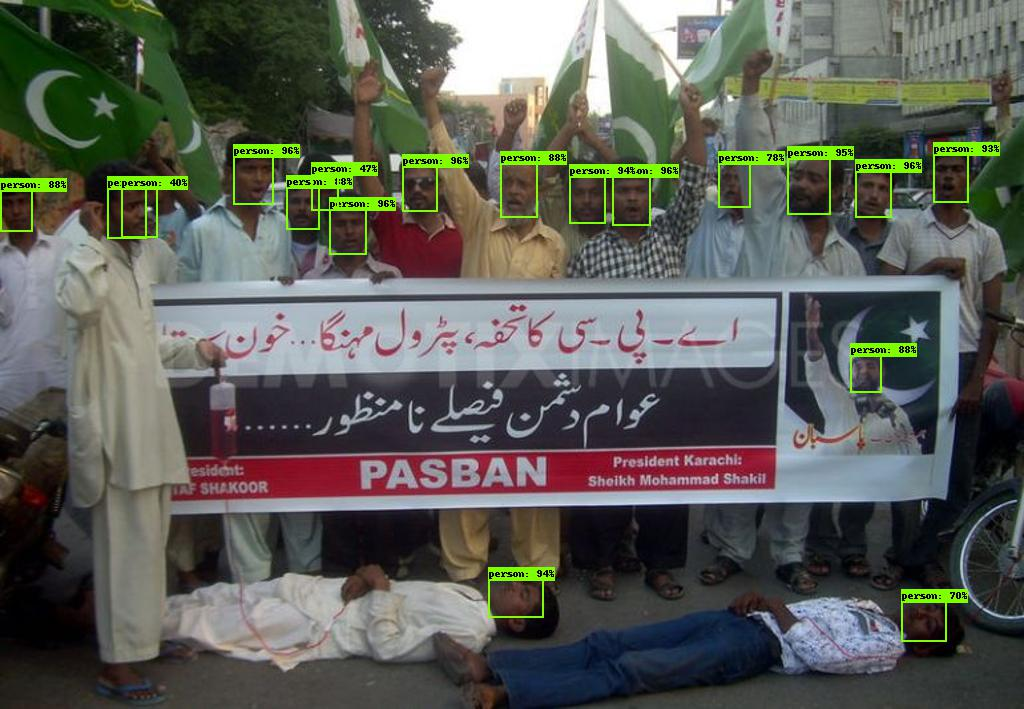

In [ ]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))